In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import tensorflow as tf
from joblib import Parallel, delayed

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

2024-12-06 12:16:46.832023: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 12:16:46.995956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 12:16:46.996017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 12:16:47.051082: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 12:16:47.104220: I tensorflow/core/platform/cpu_feature_gua

In [2]:
ds = xr.open_dataset('../rainFlagRemovedBuoyDataBadQualityRemovedMatchup.nc')
df = ds.to_dataframe()
df_orig = df.copy()

In [3]:
df['cos(Direction Difference (QuikSCAT - TAO))'] = np.cos(np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))
df['sin(Direction Difference (QuikSCAT - TAO))'] = np.sin(np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))


df['cos(Wind Direction (TAO))'] = np.cos(np.deg2rad(df['Wind Direction (TAO)']))
df['sin(Wind Direction (TAO))'] = np.sin(np.deg2rad(df['Wind Direction (TAO)']))

df['cos(Wind Direction (QuikSCAT))'] = np.cos(np.deg2rad(df['Wind Direction (QuikSCAT)']))
df['sin(Wind Direction (QuikSCAT))'] = np.sin(np.deg2rad(df['Wind Direction (QuikSCAT)']))


for timeWindow in range(10,730,10):
    if timeWindow == 10:
        df[f'cos (Direction) Difference {timeWindow}min (QuikSCAT - TAO)'] = df['cos(Wind Direction (QuikSCAT))'] - df['cos(Wind Direction (TAO))']
        df[f'sin (Direction) Difference {timeWindow}min (QuikSCAT - TAO)'] = df['sin(Wind Direction (QuikSCAT))'] - df['sin(Wind Direction (TAO))']

        df[f'speed Difference {timeWindow}min (QuikSCAT - TAO)'] = df['Wind Speed (QuikSCAT)'] - df['Neutral Wind Speed at 10m (TAO)']
    else:
        df[f'cos (Direction) Difference {timeWindow}min (QuikSCAT - TAO)'] = df['cos(Wind Direction (QuikSCAT))'] - df[f'mean cosWDIR {timeWindow}min']
        df[f'sin (Direction) Difference {timeWindow}min (QuikSCAT - TAO)'] = df['sin(Wind Direction (QuikSCAT))'] - df[f'mean sinWDIR {timeWindow}min']
        df[f'speed Difference {timeWindow}min (QuikSCAT - TAO)'] = df['Wind Speed (QuikSCAT)'] - df[f'mean WSPD_10N {timeWindow}min']
    

/tmp/ipykernel_2041135/3614314299.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'speed Difference {timeWindow}min (QuikSCAT - TAO)'] = df['Wind Speed (QuikSCAT)'] - df[f'mean WSPD_10N {timeWindow}min']
/tmp/ipykernel_2041135/3614314299.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cos (Direction) Difference {timeWindow}min (QuikSCAT - TAO)'] = df['cos(Wind Direction (QuikSCAT))'] - df[f'mean cosWDIR {timeWindow}min']
/tmp/ipykernel_2041135/3614314299.py:20: PerformanceWarning: DataFrame is highly fragmente

/tmp/ipykernel_2041135/1514333505.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['label'] = dbscan.fit_predict(normX)
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-package

Text(0.1, 0.95, 'B')

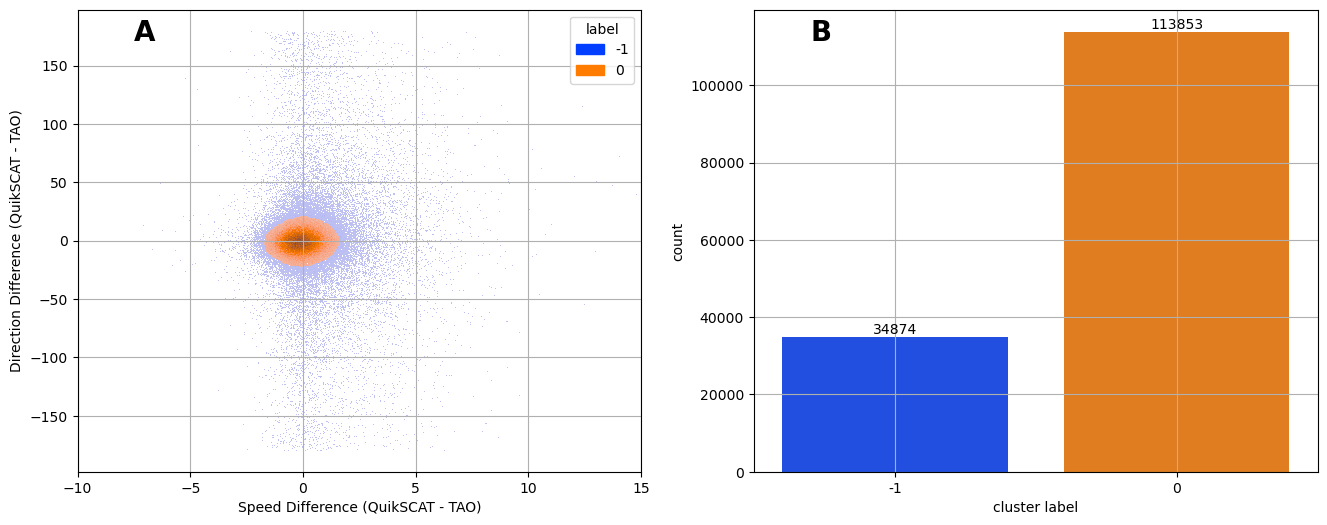

In [4]:
selectX = ['Speed Difference (QuikSCAT - TAO)',
          'cos(Direction Difference (QuikSCAT - TAO))',
          'sin(Direction Difference (QuikSCAT - TAO))']


X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=17, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

dbscan = DBSCAN(eps=0.15, min_samples= 500)
df['label'] = dbscan.fit_predict(normX)

# optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True, #cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

In [6]:
list(df.keys())

['Wind Direction (TAO)',
 'WDIR_QC',
 'WDIR_DM',
 'Wind Speed (TAO)',
 'WSPD_QC',
 'WSPD_DM',
 'Zonal Wind Speed (TAO)',
 'Meridional Wind Speed (TAO)',
 'Sea Surface Temperature (TAO)',
 'SST_QC',
 'SST_DM',
 'Relative Humidity (TAO)',
 'RELH_QC',
 'RELH_DM',
 'Air Temperature (TAO)',
 'AIRT_QC',
 'AIRT_DM',
 'Neutral Wind Speed at 10m (TAO)',
 'Wind Speed at 10m (TAO)',
 'mean WSPD 20min',
 'std. dev. WSPD 20min',
 'mean WSPD_10N 20min',
 'std. dev. WSPD_10N 20min',
 'mean Ux_10N 20min',
 'std. dev. Ux_10N 20min',
 'mean Vy_10N 20min',
 'std. dev. Vy_10N 20min',
 'mean WDIR 20min',
 'std. dev. WDIR 20min',
 'mean cosWDIR 20min',
 'std. dev. cosWDIR 20min',
 'mean sinWDIR 20min',
 'std. dev. sinWDIR 20min',
 'mean WSPD 30min',
 'std. dev. WSPD 30min',
 'mean WSPD_10N 30min',
 'std. dev. WSPD_10N 30min',
 'mean Ux_10N 30min',
 'std. dev. Ux_10N 30min',
 'mean Vy_10N 30min',
 'std. dev. Vy_10N 30min',
 'mean WDIR 30min',
 'std. dev. WDIR 30min',
 'mean cosWDIR 30min',
 'std. dev. cosWDI